In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [2]:
%pip install torch --quiet
import torch
import torch.nn as nn
import torch.nn.functional as F

# Checking the version of Pytorch
print(torch.__version__)

# Device Agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The device being used is: {device}")

Note: you may need to restart the kernel to use updated packages.
2.5.1+cu121
The device being used is: cuda


In [3]:
BREEDS_DIR = "/kaggle/input/23-pet-breeds-image-classification/Pet_Breeds"

breeds = [breed for breed in os.listdir(BREEDS_DIR)]
print(f"The number of pet breeds in the dataset: {len(breeds)}")

breeds

The number of pet breeds in the dataset: 23


['husky',
 'beagle',
 'pomeranian',
 'mumbai cat',
 'siamese cat',
 'german shepherd',
 'pug',
 'persian cat',
 'american shorthair',
 'ragdoll cat',
 'chihuahua',
 'maine coon',
 'bulldog',
 'abyssinian',
 'boxer',
 'sphynx',
 'golden retriever',
 'labrador',
 'shiba inu',
 'dachshund',
 'rottwiler',
 'corgi',
 'yorkshire terrier']

In [4]:
breed_to_idx = {breed: idx for idx, breed in enumerate(breeds)}

data = []
for breed in breeds:
    breed_path = os.path.join(BREEDS_DIR, breed)
    for image in os.listdir(breed_path):
        image_path = os.path.join(breed_path, image)
        data.append([image_path, breed, breed_to_idx[breed]])

data = pd.DataFrame(data, columns=["image_path","breed", "breed_idx"])
data.head(10)

,image_path,breed,breed_idx
0,/kaggle/input/23-pet-breeds-image-classificati...,husky,0
1,/kaggle/input/23-pet-breeds-image-classificati...,husky,0
2,/kaggle/input/23-pet-breeds-image-classificati...,husky,0
3,/kaggle/input/23-pet-breeds-image-classificati...,husky,0
4,/kaggle/input/23-pet-breeds-image-classificati...,husky,0
5,/kaggle/input/23-pet-breeds-image-classificati...,husky,0
6,/kaggle/input/23-pet-breeds-image-classificati...,husky,0
7,/kaggle/input/23-pet-breeds-image-classificati...,husky,0
8,/kaggle/input/23-pet-breeds-image-classificati...,husky,0
9,/kaggle/input/23-pet-breeds-image-classificati...,husky,0


In [5]:
total_images = 0
for breed in breeds:
  no_of_img = data['breed'][data['breed'] == breed].count() # Filter the 'breed' column by the current breed and get the count
  print(f"The number of images of breed {breed} is {no_of_img}")
  total_images += no_of_img

print("="*50)
print('Total pet images: ',total_images)

The number of images of breed husky is 170
The number of images of breed beagle is 170
The number of images of breed pomeranian is 170
The number of images of breed mumbai cat is 141
The number of images of breed siamese cat is 170
The number of images of breed german shepherd is 170
The number of images of breed pug is 170
The number of images of breed persian cat is 170
The number of images of breed american shorthair is 170
The number of images of breed ragdoll cat is 170
The number of images of breed chihuahua is 170
The number of images of breed maine coon is 170
The number of images of breed bulldog is 170
The number of images of breed abyssinian is 170
The number of images of breed boxer is 170
The number of images of breed sphynx is 170
The number of images of breed golden retriever is 170
The number of images of breed labrador is 170
The number of images of breed shiba inu is 170
The number of images of breed dachshund is 170
The number of images of breed rottwiler is 170
The 

In [6]:
# Preprocessing and Dataset Class
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Dataset Class for Pet Classification
class PetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['breed_idx']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforming the Images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

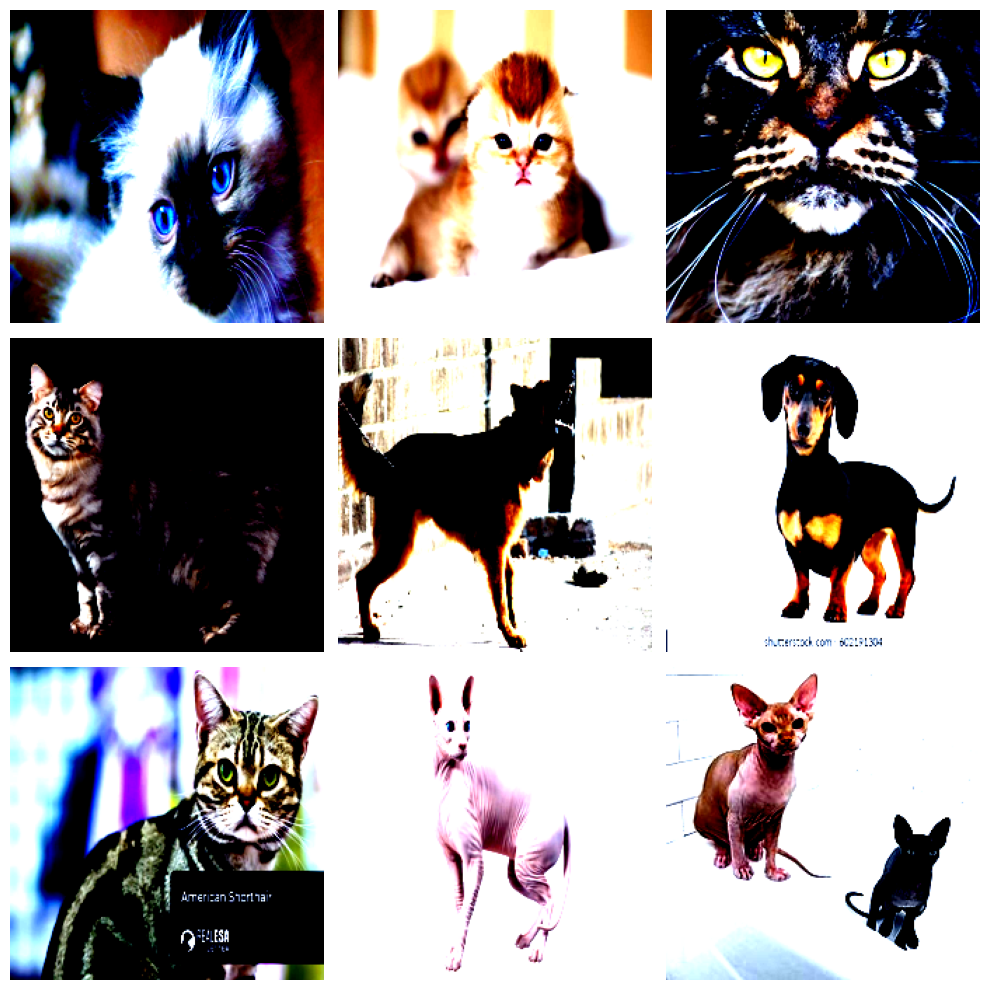

In [7]:
import random

# Select random image paths from the dataset
sample_image_paths = random.sample(data['image_path'].tolist(), 9)

# Apply transformations and store tensors in a list
image_tensors = []
for image_path in sample_image_paths:
    image = Image.open(image_path).convert('RGB')
    transformed_image = transform(image)
    image_tensors.append(transformed_image)

# Stack tensors into a batch (optional, if needed later)
# image_tensors = torch.stack(image_tensors)

num_img = 9
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

# Display the images
for idx, image_tensor in enumerate(image_tensors[:num_img]):
    # Convert the tensor to a NumPy array for display
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    # Un-normalize the image (reverse normalization)
    # image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    # image_np = np.clip(image_np, 0, 1)  # Ensure values are in the range [0, 1]

    axes[idx].imshow(image_np)
    axes[idx].axis('off')  

plt.tight_layout() 
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score

class HierarchicalPetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HierarchicalPetClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pet_classifier = HierarchicalPetClassifier(num_classes=len(breeds)).to(device)

In [9]:
import torch.optim as optim
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# Loss Function
criterion = nn.CrossEntropyLoss()
# Gardient Descent Weight updation
optimizer = torch.optim.Adam(pet_classifier.parameters(), lr=1e-4)

# Custom Learning Rate Scheduler
class CustomLRScheduler:
    def __init__(self, optimizer, patience=3, factor=5):
        self.optimizer = optimizer
        self.patience = patience
        self.factor = factor
        self.best_loss = None
        self.counter = 0

    def step(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            for param_group in self.optimizer.param_groups:
                param_group['lr'] *= self.factor
            print(f"Learning rate increased by a factor of {self.factor}. New LR: {self.optimizer.param_groups[0]['lr']}")
            self.counter = 0
            self.best_loss = current_loss
        else:
           for param_group in self.optimizer.param_groups:
               param_group['lr'] = 1e-5 # Resetting to initial LR
               print(f"LR is {self.optimizer.param_groups[0]['lr']}")

# Initialize the custom learning rate scheduler
lr_scheduler = CustomLRScheduler(optimizer)
print(lr_scheduler)

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Making Training, Validation and Testing Dataloaders
train_df, test_df = train_test_split(data, test_size=0.2,
                                     random_state=42,
                                     stratify=data['breed_idx'])

train_df, val_df = train_test_split(train_df, test_size=0.2,
                                    random_state=42,
                                    stratify=train_df['breed']
                                   )

# Creating Dataset Objects for DataLoaders
train_dataset = PetDataset(train_df, transform=transform)
val_dataset = PetDataset(val_df, transform=transform)
test_dataset = PetDataset(test_df, transform=transform)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Verify DataLoader
for images, labels in train_loader:
    print(images.shape, labels.shape)  # Should print torch.Size([32, 3, 224, 224]), (32,)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

num_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize the custom learning rate scheduler
lr_scheduler = CustomLRScheduler(optimizer)

for epoch in range(num_epochs):
    # Training Phase
    pet_classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    train_labels, train_preds = [], []
    
    for images, labels in tqdm(train_loader,
                               desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pet_classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predicted.cpu().numpy())
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(accuracy_score(train_labels, train_preds))
    
    # Validation Phase
    pet_classifier.eval()
    val_running_loss, val_labels, val_preds = 0.0, [], []
    
    # with torch.no_grad():
    for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        outputs = pet_classifier(images)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_labels.extend(labels.cpu().numpy())
        val_preds.extend(predicted.cpu().numpy())
    
    val_losses.append(val_running_loss / len(val_loader))
    val_accuracies.append(accuracy_score(val_labels, val_preds))
    
    # Step the LR scheduler after the validation phase
    lr_scheduler.step(val_losses[-1])  # Use validation loss to update learning rate
    
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.4f}, "
          f"Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.4f}")

# Plotting the loss and accuracy curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Validation Epoch 1: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


LR is 1e-05
Epoch 1: Train Loss=3.1858, Train Acc=0.0785, Val Loss=2.9225, Val Acc=0.1224


Training Epoch 2/100:  23%|██▎       | 18/78 [00:14<00:42,  1.41it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score
from tqdm import tqdm

# Testing Phase
pet_classifier.eval()
test_loss = 0.0  # Initialize test loss
test_labels, test_preds = [], []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        # Move inputs and labels to the device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = pet_classifier(inputs)
        loss = criterion(outputs, labels)  # Calculate batch loss
        test_loss += loss.item()  # Accumulate batch loss
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())  # Move labels to CPU
        test_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU

# Calculate Average Test Loss
avg_test_loss = test_loss / len(test_loader)

# Calculate Metrics
accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted')

# Print Results
print(f"\n Test Results ")
print("="*50)
print(f"🔹 Test Loss: {avg_test_loss:.4f}")
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 Precision: {precision:.4f}")

# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(test_labels)))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()